<h3 style="color:green">Описание проекта</h3>


В крупном интернет-магазине провели A/B тест, результаты проведения такого теста записали в два файла: 'orders' и 'visitors'


Описание файла "orders"

    transactionId — ID заказа;
    visitorId — ID посетителя;
    date — дата совершения заказа;
    revenue — выручка;
    group — группа теста.
    
Описание файла "visitors"

    date — дата;
    group — группа теста;
    visitors — количество посетителей 
    
    
Необходимо изучить результаты и определить успешность проводимого теста.

<h3 style="color:green">Импорт библиотек</h3>

In [1]:
from scipy import stats as st
import scipy.stats as stats
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.1f}'.format

<h2 style="color:green">Импорт данных</h2>

In [2]:
orders = pd.read_csv('C://Users\Sergei/2020_portfolio_projects/orders.csv')
visitors = pd.read_csv('C://Users\Sergei/2020_portfolio_projects/visitors.csv')
print('Таблица "orders"')
print(orders.head(3))
print(orders.info())
print()
print('Таблица "visitors" ')
print(visitors.head(3))
print(visitors.info())

Таблица "orders"
   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     1650     B
1     2804400009  3642806036  2019-08-15      730     B
2     2961555356  4069496402  2019-08-15      400     A
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

Таблица "visitors" 
         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


В данных нет пропусков, можно разбираться с типами данных

<h3 style="color:green">Приведение данных с датой к формату даты, нахождение уникальных пар дата/группа для группировки </h3>

In [3]:
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [4]:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
    orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max',
    'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [5]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
     visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
                                       axis=1).sort_values(by=['date','group'])

<h3 style="color:green">Обьединение таблиц для возможности выполнять расчёты, для каждого дня есть суммарные данные за весь прошедший период </h3>

In [6]:
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [7]:
print(cummulativeData.head(5))

        date group  transactionId  visitorId  revenue  visitors
0 2019-08-01     A             24         20   148579       719
1 2019-08-01     B             21         20   101217       713
2 2019-08-02     A             44         38   242401      1338
3 2019-08-02     B             45         43   266748      1294
4 2019-08-03     A             68         62   354874      1845


In [8]:
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

<h3 style="color:green">Кумулятивная выручка с разбивкой по дням и группам A/B </h3>

C:\Users\Sergei\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


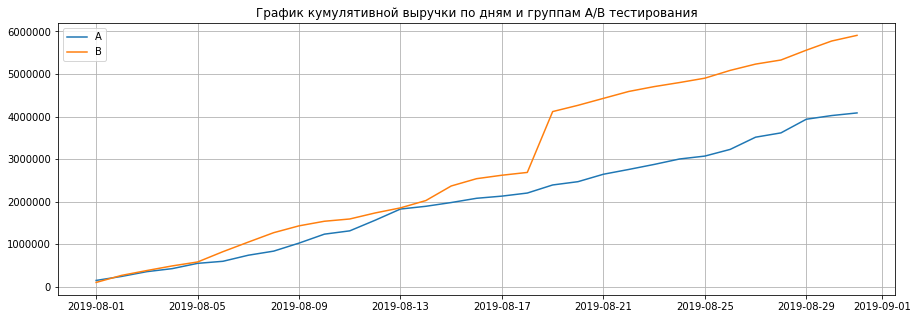

In [9]:
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]
cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]
fig = plt.figure(figsize=(15,5))
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')
plt.legend()
plt.grid()
plt.title('График кумулятивной выручки по дням и группам А/В тестирования')
plt.show()

 19.08.19 на графике виден сильный скачок для группы В, скорей всего в этот день можно найти аномальные значения, выделяющиеся из общей выборки. После этого рост выручки очень похож на рост выручки для группы А, об этом говорит параллельность линий.
 
 <font color='blue'> Все правильно построено, но стоило предположить причины скачка. </font>

<h3 style="color:green">Средний чек с разбивкой по дням и группам A/B </h3>

Text(0.5, 1.0, 'Средний чек по дням и группам А/В тестирования')

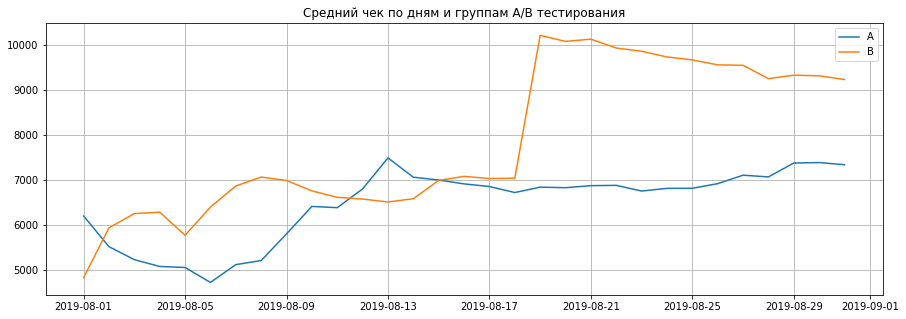

In [10]:

fig = plt.figure(figsize=(15,5))
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'] / cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'] / cummulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.title('Средний чек по дням и группам А/В тестирования')

на графике среднего чека скачок заметен ещё больше, а то что после этого средний чек стал понижаться говорит о том, что со временем аномалия, которая произошла 19.08.19 стала сглаживаться за счёт большого количества данных. Большей выручке и большем количестве заказов.

<font color='blue'>все правильно. </font>

<h3 style="color:green">Относительное изменение кумулятивного среднего чекв группы В к группе А </h3>

Text(0.5, 1.0, 'Относительное изменение кумулятивного среднего чека группы B к группе А')

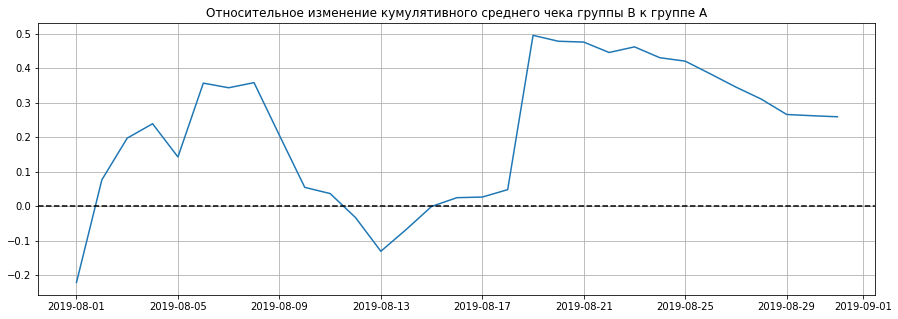

In [11]:
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date',
                                                     how='left', suffixes=['A', 'B'])
fig = plt.figure(figsize=(15,5))
plt.plot(mergedCummulativeRevenue['date'], 
         (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB']
         )/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')

plt.grid()
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе А')

относительное изменение среднего чека показывает, что аномальные изменения были не только 19.08.19, ещё и в начале теста 04-08.08.19.

<font color='blue'> Верно, но стоило подчеркнуть что все тр  графика показывают одинаковую картину. </font>

<h3 style="color:green">Кумулятивная конверсия по группам</h3>

Text(0.5, 1.0, 'Кумулятивная конверсия по группам')

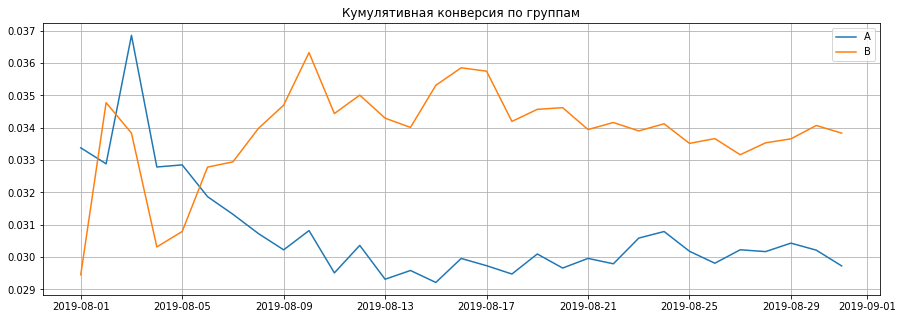

In [12]:
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']
fig = plt.figure(figsize=(15,5))
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
plt.legend()
plt.grid()
plt.title('Кумулятивная конверсия по группам')

до 08.08.19 конверсия в обоих группах была очень нестабильная, отсутствие больших изменений 18.08.19 говорит о том, что та аномалия была связана с величиной заказа, а не количеством заказов. В начале теста есть скачки в среднем чеке и конверсии, но нет в суммарной выручке, значит эти показатели нивелировали друг друга.

<font color='blue'> Отлично построено. </font>

<h3 style="color:green">Относительное изменение кумулятивной конверсии группы B к группе A</h3>

Text(0.5, 1.0, 'Относительное изменение кумулятивной конверсии группы B к группе A')

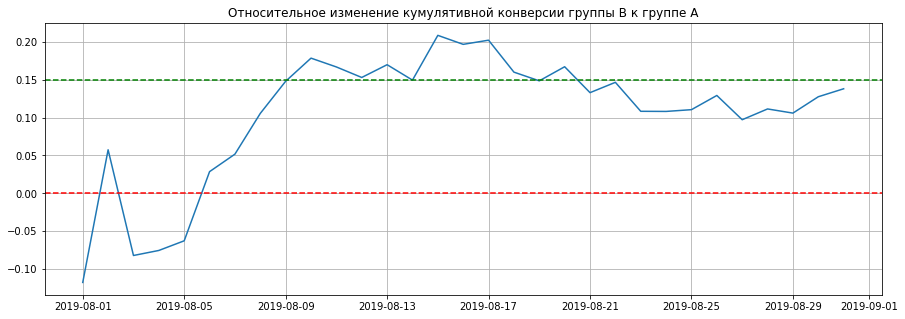

In [13]:
mergedCummulativeConversions = cummulativeDataA[['date','conversion']].merge(cummulativeDataB[['date','conversion']],
                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
fig = plt.figure(figsize=(15,5))
plt.plot(mergedCummulativeConversions['date'], 
         mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1)

plt.grid()
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.15, color='green', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')

на этом графике тоже видно, что в начале теста конверсия была нестабилной, к окончанию видно, что конверсия стабилизировалась и конверсия группы В чуть выше.

<font color='blue'> Хорошо. </font>

<h3 style="color:green">Поиск аномальных значений стоимости заказа и количества заказов на одного покупателя</h3>

95-ый процентиль количества заказов: 2 заказа
99-ый процентиль количества заказов: 4 заказа


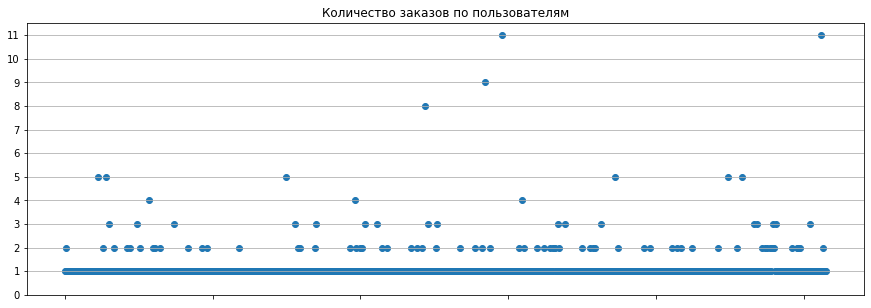

In [14]:
x_values = pd.Series(range(0,len(orders.groupby('visitorId')['transactionId'].count())))
fig = plt.figure(figsize=(15,5))
plt.scatter(x_values ,orders.groupby('visitorId', as_index = False)['transactionId'].count()['transactionId'])
plt.yticks([x*1 for x in range(12)])
plt.grid(axis = 'y')
plt.xticks([0.,  200.,  400.,  600.,  800., 1000.], labels = '')
plt.title('Количество заказов по пользователям')
print('95-ый процентиль количества заказов: {:.0f} заказа'.format(np.percentile(orders.groupby('visitorId', 
      as_index = False)['transactionId'].count()['transactionId'], [95])[0]))
print('99-ый процентиль количества заказов: {:.0f} заказа'.format(np.percentile(orders.groupby('visitorId', 
      as_index = False)['transactionId'].count()['transactionId'], [99])[0]))

Процентили подтверждают наглядную картину, что редкий пользователь совершит 5 и более заказов, а основная масса делает 1-2 заказа.

95-ый процентиль стоимости заказов: 28000 единиц выручки
99-ый процентиль стоимости заказов: 58233 единиц выручки


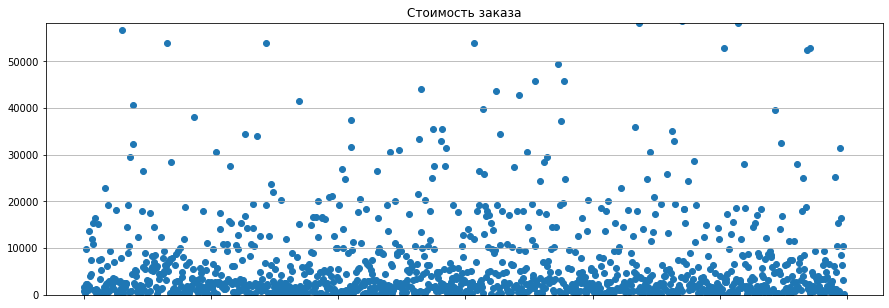

In [15]:
fig = plt.figure(figsize=(15,5))
plt.scatter(orders.index, orders['revenue'])
plt.ylim(0, 58223)
plt.grid(axis = 'y')
plt.xticks([ 0.,  200.,  400.,  600.,  800., 1000., 1200.], labels = '')
# plt.yticks([    0., 10000., 20000., 30000., 40000., 50000., 58223.])
plt.title('Стоимость заказа')
print('95-ый процентиль стоимости заказов: {:.0f} единиц выручки'.format(np.percentile(orders['revenue'], [95])[0]))
print('99-ый процентиль стоимости заказов: {:.0f} единиц выручки'.format(np.percentile(orders['revenue'], [99])[0]))


На графике тяжело определить сколько заказов составляет 95 и 99 процентилей от всей выборки, точные подсчёты определяют эту границу гораздо проще.

<h3 style="color:green">Обьединённая таблица с кумулятивными данными из таблиц с заказами и данными о визитах</h3>

In [16]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


<h3 style="color:green">Проверка гипотез для отсортированных по группам данных</h3>
<h3 style="color:green">Равенство конверсий и среднего чека в группах А и В</h3>

In [17]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0,
      index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0,
      index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
print("p-value нулевой гипотезы о равенстве конверсий в группах А и В: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост группы B составляет: {0:.2%}".format(sampleB.mean()/sampleA.mean()-1))
print("p-value нулевой гипотезы о равенстве среднего чека в группах А и В: {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print("Относительный прирост среднего чека в группе B: {0:.2%}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value нулевой гипотезы о равенстве конверсий в группах А и В: 0.008
Относительный прирост группы B составляет: 13.81%
p-value нулевой гипотезы о равенстве среднего чека в группах А и В: 0.365
Относительный прирост среднего чека в группе B: 25.87%


Нулевая гипотеза о равенстве конверсий в группах отклонена при p-value равном 0.008, относительный прирост составляет 13.81%, это неплохой показатель, но нужно понять не случилось ли такое изменение благодаря всего нескольким случайным аномальным событиям

Нулевая гипотеза о равенств среднего чека не может быть отклонена, при p-value равном 0.365 это слишком большая вероятность получить такую разницу случайно. Средний чек отличается, относительный прирост в 25.87% это подтверждает.

<font color='blue'> Да, все верно. </font>

<h3 style="color:green">Нахождение пользователей с аномальными значениями количества заказов и стоимости заказа</h3>

In [18]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print('Количество пользователей c аномальными значениями  в заказах в пределах 95-го процентиля: {:.0f}'.format(len(abnormalUsers)))

Количество пользователей c аномальными значениями  в заказах в пределах 95-го процентиля: 68


<h3 style="color:green">Фильтр данных и проведение тестирования гипотез</h3>

In [19]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],axis=0)

print("p-value нулевой гипотезы о равенстве конверсий в группах А и В для 95 процентилей: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered,
                                                                                                          sampleBFiltered)[1]))

print("Относительный прирост группы B для 95 процентилей составляет: {0:.2%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

print("p-value нулевой гипотезы о равенстве среднего чека в группах А и В для 95 процентилей: {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("Относительный прирост среднего чека в группе B для 95 процентилей: {0:.2%}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))



p-value нулевой гипотезы о равенстве конверсий в группах А и В для 95 процентилей: 0.006
Относительный прирост группы B для 95 процентилей составляет: 20.43%
p-value нулевой гипотезы о равенстве среднего чека в группах А и В для 95 процентилей: 0.394
Относительный прирост среднего чека в группе B для 95 процентилей: -1.66%


<font color='blue'> Гипотезы проверены верно. </font>

<h3 style="color:green">Результаты тестирования</h3>

 - Количество пользователей c аномальными значениями  в заказах в пределах 95-го процентиля: 68
 - p-value нулевой гипотезы о равенстве конверсий в группах А и В для 95 процентилей: 0.006
 - Относительный прирост группы B для 95 процентилей составляет: 20.43%
 - p-value нулевой гипотезы о равенстве среднего чека в группах А и В для 95 процентилей: 0.394
 - Относительный прирост среднего чека в группе B для 95 процентилей: -1.66%

- Количество пользователей c аномальными значениями  в заказах в пределах 99-го процентиля: 15
- p-value нулевой гипотезы о равенстве конверсий в группах А и В для 99 процентиля: 0.007
- Относительный прирост группы B для 99 процентиля составляет: 15.33%
- p-value нулевой гипотезы о равенстве среднего чека в группах А и В для 99 процентиля: 0.425
- Относительный прирост среднего чека в группе B для 99 процентиля: -0.57%



Данные без фильтра:
 - p-value нулевой гипотезы о равенстве конверсий в группах А и В: 0.008
 - Относительный прирост группы B составляет: 13.81%
 - p-value нулевой гипотезы о равенстве среднего чека в группах А и В: 0.365
 - Относительный прирост среднего чека в группе B: 25.87%

<h3 style="color:green">Итоги тестирования</h3>

Для лучшего понимания влияния аномальных значений на результаты тестирования гипотез использовались и 95 и 99 процентили.

 - Во всех случаях гипотеза о равенстве конверсий может быть отколнена, p-value слишком мал
 - Относительный прирост конверсии с 13.81% поднимается до 20.43% при фильтрации данных
 - Гипотезу о равенстве среднего чека во всех случаях нельзя отклонить, такие различия можно получить и случайно.
 - Относительный прирост при фильтрации данных сходит на нет и даже становится отрицательным для группы В
 
 Эти результаты говорят о том, что конверсия для группы В действительно выше группы А, а средний чек с большой вероятностью одинаковый, различия возникли из за аномальных заказов.

<h3 style="color:green">Графики для данных с фильтром по 95 процентилю</h3>

In [20]:
# повторим агрегацию данных с исключением из расчёта пользователей с аномальными значениями
orders_filtered = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]

In [21]:
datesGroups_filtered = orders_filtered[['date','group']].drop_duplicates()
ordersAggregated_filtered = datesGroups.apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date'] <= x['date'],
    orders_filtered['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max',
    'transactionId' : pd.Series.nunique, 
    'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated_filtered = datesGroups_filtered.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
     visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
                                       axis=1).sort_values(by=['date','group'])

In [22]:
cummulativeData_filtered = ordersAggregated_filtered.merge(visitorsAggregated, left_on=['date', 'group'], 
                                                           right_on=['date', 'group'])
cummulativeData_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [23]:
cummulativeRevenueA_filtered = cummulativeData_filtered[cummulativeData_filtered['group']=='A'][['date','revenue', 'orders']]
cummulativeRevenueB_filtered = cummulativeData_filtered[cummulativeData_filtered['group']=='B'][['date','revenue', 'orders']]

In [24]:
mergedCummulativeRevenue_filtered = cummulativeRevenueA_filtered.merge(cummulativeRevenueB_filtered, left_on='date',
        right_on='date',how='left', suffixes=['A', 'B'])


In [25]:
cummulativeData_filtered['conversion'] = cummulativeData_filtered['orders']/cummulativeData_filtered['visitors']
cummulativeDataA_filtered = cummulativeData_filtered[cummulativeData_filtered['group']=='A']
cummulativeDataB_filtered = cummulativeData_filtered[cummulativeData_filtered['group']=='B']


In [26]:
mergedCummulativeConversions_filtered = cummulativeDataA_filtered[['date',
      'conversion']].merge(cummulativeDataB_filtered[['date','conversion']],
                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])



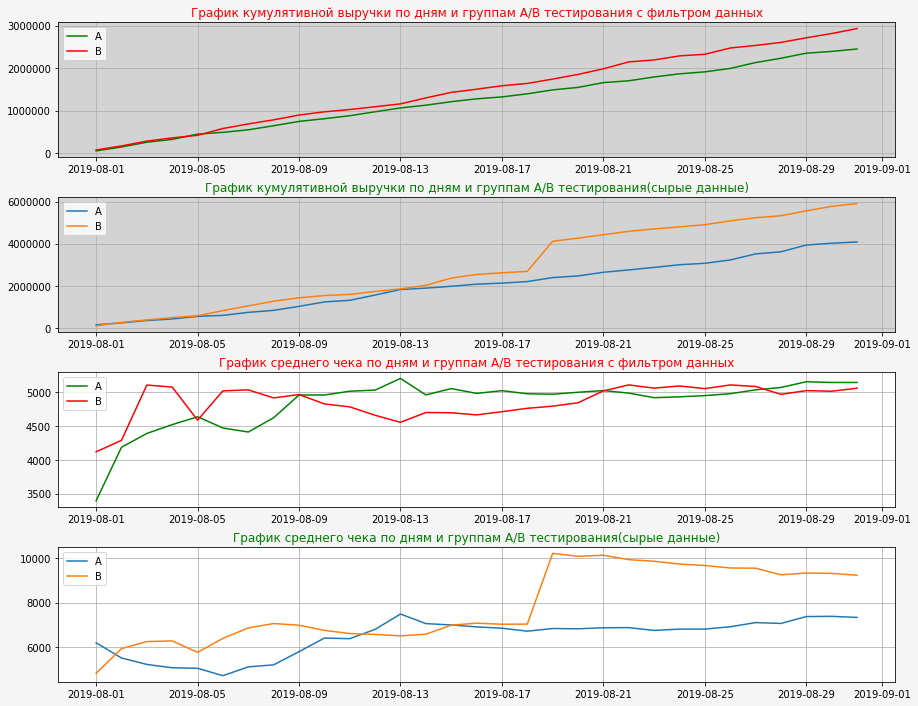

In [29]:
# выведем на печать графики по всем данным и данным без аномальных значений, ограниченных 95 процентилем.
fig = plt.figure(figsize=(15,25))
fig.subplots_adjust(hspace=0.3)
fig.set_facecolor('whitesmoke')

ax1 = fig.add_subplot(811)
ax1.set_facecolor('lightgrey')
plt.plot(cummulativeRevenueA_filtered['date'], cummulativeRevenueA_filtered['revenue'], label='A',color = 'green')
plt.plot(cummulativeRevenueB_filtered['date'], cummulativeRevenueB_filtered['revenue'], label='B',color = 'red')
plt.legend()
plt.grid()
plt.title('График кумулятивной выручки по дням и группам А/В тестирования c фильтром данных',color = 'red')

ax2 = fig.add_subplot(812)
ax2.set_facecolor('lightgrey')
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')
plt.legend()
plt.grid()
plt.title('График кумулятивной выручки по дням и группам А/В тестирования(сырые данные)',color = 'green')


ax1 = fig.add_subplot(813)
plt.plot(cummulativeRevenueA_filtered['date'],
         cummulativeRevenueA_filtered['revenue'] / cummulativeRevenueA_filtered['orders'], label='A',color = 'green')
plt.plot(cummulativeRevenueB_filtered['date'],
         cummulativeRevenueB_filtered['revenue'] / cummulativeRevenueB_filtered['orders'], label='B',color = 'red')
plt.legend()
plt.grid()
plt.title('График среднего чека по дням и группам А/В тестирования с фильтром данных',color = 'red')

ax2 = fig.add_subplot(814)
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'] / cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'] / cummulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.title('График среднего чека по дням и группам А/В тестирования(сырые данные)',color = 'green')

plt.show()

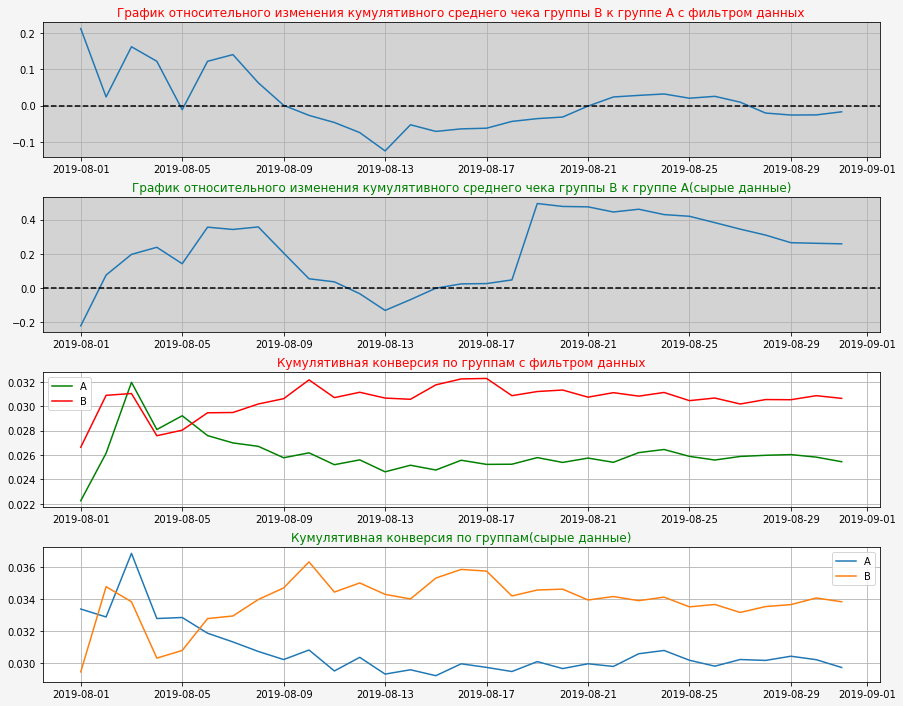

In [30]:
fig = plt.figure(figsize=(15,25))
fig.subplots_adjust(hspace=0.3)
fig.set_facecolor('whitesmoke')


ax1 = fig.add_subplot(815)
ax1.set_facecolor('lightgrey')
plt.plot(mergedCummulativeRevenue_filtered['date'], 
         (mergedCummulativeRevenue_filtered['revenueB']/mergedCummulativeRevenue_filtered['ordersB']
         )/(mergedCummulativeRevenue_filtered['revenueA']/mergedCummulativeRevenue_filtered['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')

plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе А с фильтром данных',color = 'red')


ax1 = fig.add_subplot(816)
ax1.set_facecolor('lightgrey')
plt.plot(mergedCummulativeRevenue['date'], 
         (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB']
         )/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')

plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе А(сырые данные)',color = 'green')

ax1 = fig.add_subplot(817)
plt.plot(cummulativeDataA_filtered['date'], cummulativeDataA_filtered['conversion'], label='A',color = 'green')
plt.plot(cummulativeDataB_filtered['date'], cummulativeDataB_filtered['conversion'], label='B',color = 'red')
plt.legend()
plt.grid()
plt.title('Кумулятивная конверсия по группам с фильтром данных',color = 'red')

ax1 = fig.add_subplot(818)

plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
plt.legend()
plt.grid()
plt.title('Кумулятивная конверсия по группам(сырые данные)',color = 'green')
plt.show()






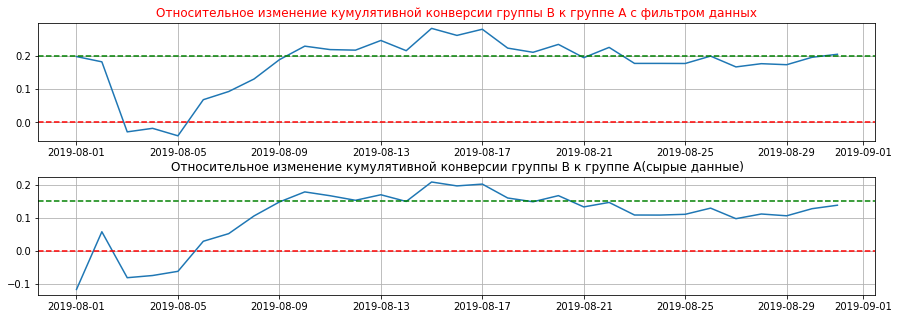

In [31]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(211)

plt.plot(mergedCummulativeConversions_filtered['date'], 
         mergedCummulativeConversions_filtered['conversionB']/mergedCummulativeConversions_filtered['conversionA']-1)

plt.grid()
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.2, color='green', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A с фильтром данных',color = 'red')
,

ax1 = fig.add_subplot(212)
plt.plot(mergedCummulativeConversions['date'], 
         mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1)

plt.grid()
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.15, color='green', linestyle='--')
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A(сырые данные)')
plt.show()

<h3 style="color:green">Графики по покупателям с аномальными заказами</h3>

Text(0.5, 1.0, 'Количество аномальных заказов')

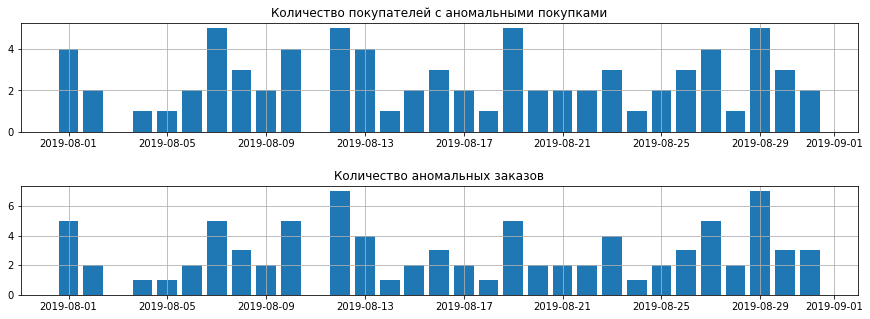

In [28]:
anomaly = orders[orders['visitorId'].isin(usersWithExpensiveOrders)].groupby('date').agg({'transactionId':'count',
                        'visitorId':'nunique'}).reset_index()

fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.5)


ax1 = fig.add_subplot(211)
plt.bar(anomaly['date'],anomaly['visitorId'])
plt.grid()
plt.title('Количество покупателей с аномальными покупками')


ax1 = fig.add_subplot(212)
plt.bar(anomaly['date'],anomaly['transactionId'])
plt.grid()
plt.title('Количество аномальных заказов')


<h2 style="color:green">Вывод</h2>


По графикам видно, что ситуация по ключевым показателям стабилизировалась, А/В тестирование можно прекращать. Тест показал, что в группе В есть прирост конверсии в 14-20 процентов.

Аномальные значения встречались достаточно регулярно, значит в большей степени данные были искажены высокой стоимостью заказа.

Тест можно считать успешным


